# Tutorial 1: 2D pressure fluctuations in a turbulent jet

In this tutorial we explore a small dataset provided with this package that contains the flow exiting a nozzle (also referred to as a jet). The data is two-dimensional and it is provided in equally-spaced cylindrical coordinates _(r,x)_.

## Import required libraries

The first step is to import the required libraries.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import sys
import numpy as np

# Current, parent and file paths
CWD = os.getcwd()
CFD = os.path.abspath('')

# project libraries
sys.path.append(os.path.join(CFD,"../../"))

# Import library specific modules
from pyspod.spod.standard  import Standard  as spod_standard
from pyspod.spod.streaming import Streaming as spod_streaming
import pyspod.spod.utils     as utils_spod
import pyspod.utils.weights  as utils_weights
import pyspod.utils.errors   as utils_errors
import pyspod.utils.io       as utils_io
import pyspod.utils.postproc as post

## Setup MPI Communicator for parallel computation (if available)

The second steps consists of setting up the MPI Communicator, if we want to run a parallel computation. 
This step requires that the user has a version of MPI installed in their machine / HPC system. Currently tested MPI platforms include Open MPI, and mpich. 

In [15]:
## -------------------------------------------------------------------
## initialize MPI
## -------------------------------------------------------------------
try:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
    rank = comm.rank
except:
    comm = None
    rank = 0
## -------------------------------------------------------------------

## Read data and parameters

We can now read the data and the parameters from `fluidmechanics_data.mat`, and `input_tutorial1.yaml`, respectively. Both files are in `tests/data`. The input file contains some parameters that are required and some that are optional. 

In detail:

```yaml
required:
  - time_step   : 1
  - n_space_dims: 2
  - n_variables : 1
  - n_dft       : 64

optional:
  - overlap          : 50
  - mean_type        : 'longtime'
  - normalize_weights: False
  - normalize_data   : False
  - n_modes_save     : 40
  - conf_level       : 0.95
  - reuse_blocks     : False
  - savefft          : False
  - dtype            : 'double'
  - savedir          : 'spod_results'
  - fullspectrum     : False

```

The **required parameters** are:
- `time_step`, the time step of the data, 
- `n_space_dims`, the number of spatial dimensions of the data; for 2D data this number is equal to 2, 
- `n_variables`, the number of variables; for one single field, e.g., pressure, this number is equal to 1,
- `n_dft`, the number of time snapshots in each block for the data partitioning; for this tutorial, we are using 64 time snapshots, for a dataset containing 1000 time snapshots. This means that our data will be divided into blocks of 64 time snapshots each.

The **optional parameters** are:
- `overlap`, that is whether to use an overlap region between blocks (in percentage),
- `mean_type`, the type of mean to be used; this can either be the mean of all time snapshots (`longtime`), or the the mean of each block (`blockwise`); it can also be set to `zero`, if the mean was already removed from the data,
- `normalize_weights`, whether or not to normalize the weights,
- `normalize_data`, whether or not to normalize the data,
- `n_modes_save`, the number of modes to be saved,
- `conf_level`, the confidence interval for the eigenvalues,
- `reuse_blocks`, whether to reuse pre-computed FFT blocks (if present),
- `savefft`, whether to save the FFT blocks,
- `dtype`, the data type to be used (either `single` or `double` precision),
- `savedir`, where to save the results,
- `fullspectrum`, whether to use a full spectrum (instead of half) for the FFT.

In [16]:
## -------------------------------------------------------------------
## read data and params
## -------------------------------------------------------------------
## data
data_file = os.path.join(CFD, '../../tests/data', 'fluidmechanics_data.mat')
data_dict = utils_io.read_data(data_file=data_file)
data = data_dict['p'].T
dt = data_dict['dt'][0,0]
nt = data.shape[0]
x1 = data_dict['r'].T; x1 = x1[:,0]
x2 = data_dict['x'].T; x2 = x2[0,:]
## params
config_file = os.path.join(CFD, '../../tests/data', 'input_tutorial1.yaml')
params = utils_io.read_config(config_file)
params['time_step'] = dt
## -------------------------------------------------------------------

## Compute SPOD modes

We can then initialize the SPOD algorithms, both the batch (`standard`) and the streaming (`streaming`) one:

- `standard  = spod_standard (params=params, comm=comm)`
- `streaming = spod_streaming(params=params, comm=comm)`

and compute the **SPOD modes $\phi(\mathbf{x})$**, using `spod = standard.fit(data_list=data)`.

We can also check the orthogonality of the modes using `check_orthogonality`.
The modes provided should return `flag = True`, and `ortho < 1e-15`.

In [17]:
## -------------------------------------------------------------------
## compute spod modes and check orthogonality
## -------------------------------------------------------------------
standard  = spod_standard (params=params, comm=comm)
streaming = spod_streaming(params=params, comm=comm)
spod = standard.fit(data_list=data)
results_dir = spod.savedir_sim
flag, ortho = utils_spod.check_orthogonality(
    results_dir=results_dir, mode_idx1=[1],
    mode_idx2=[0], freq_idx=[5], dtype='double',
    comm=comm)
print(f'flag = {flag},  ortho = {ortho}')
## -------------------------------------------------------------------

 
Initialize data ...
 
Initialize data
------------------------------------
- reading first time snapshot for data dimensions
- getting data dimensions
- checking weight dimensions
- distributing data (if parallel)
- loaded data into memory: 5.9604644775390625e-06 s.
- computed mean: 0.004252910614013672 s.
SPOD parameters
------------------------------------
Problem size (real)      : 0.013113021850585958 GB.
Problem size (complex)   : 0.026226043701171917 GB.
Data type for real       : <class 'numpy.float64'>
Data type for complex    : <class 'numpy.complex128'>
No. snapshots per block  : 64
Block overlap            : 32
No. of blocks            : 30
Windowing fct. (time)    : hamming
Weighting fct. (space)   : uniform
Mean                     : longtime
Number of frequencies    : 33
Time-step                : 0.2
Time snapshots           : 1000
Space dimensions         : 2
Number of variables      : 1
Normalization weights    : False
Normalization data       : False
No. modes to be

/Users/gian/Desktop/dynamics-project/PySPOD/tutorials/tutorial1/../../pyspod/spod/base.py:524: UserWarning: Parameter `weights` not equal to a `numpy.ndarray`.Using default uniform weighting
  warnings.warn(


freq: 18/33;  Elapsed time: 0.00156402587890625 s.
freq: 19/33;  Elapsed time: 0.0024950504302978516 s.
freq: 20/33;  Elapsed time: 0.0032927989959716797 s.
freq: 21/33;  Elapsed time: 0.002576112747192383 s.
freq: 22/33;  Elapsed time: 0.0021677017211914062 s.
freq: 23/33;  Elapsed time: 0.002213716506958008 s.
freq: 24/33;  Elapsed time: 0.0026862621307373047 s.
freq: 25/33;  Elapsed time: 0.0032987594604492188 s.
freq: 26/33;  Elapsed time: 0.0024929046630859375 s.
freq: 27/33;  Elapsed time: 0.0025098323822021484 s.
freq: 28/33;  Elapsed time: 0.002637147903442383 s.
freq: 29/33;  Elapsed time: 0.0031418800354003906 s.
freq: 30/33;  Elapsed time: 0.0026159286499023438 s.
freq: 31/33;  Elapsed time: 0.0033211708068847656 s.
freq: 32/33;  Elapsed time: 0.003480672836303711 s.
- Modes computation and saving: 0.0036847591400146484 s.
Weights saved in: /Users/gian/Desktop/dynamics-project/PySPOD/tutorials/tutorial1/spod_results/nfft64_novlp32_nblks30/weights.npy
Parameters dictionary sa

## Compute time coefficients

Once the modes are computed, we can calculate the **time coefficients $a(t)$**

In [9]:
## -------------------------------------------------------------------
## compute coefficients
## -------------------------------------------------------------------
file_coeffs, coeffs_dir = utils_spod.compute_coeffs_op(
    data=data, results_dir=results_dir, comm=comm)
## -------------------------------------------------------------------


Computing coefficients
------------------------------
- identified frequencies: 0.02560591697692871 s.
- data and time mean: 0.011461973190307617 s.
- retrieved modes: 0.1260991096496582 s.
- oblique projection done: 0.5134580135345459 s.
- saving completed: 0.05298614501953125 s.
-----------------------------------------
Coefficients saved in folder: /Users/gian/Desktop/dynamics-project/PySPOD/tutorials/tutorial1/spod_results/nfft64_novlp32_nblks30/coeffs_0_32/coeffs.npy
Elapsed time: 0.7302820682525635 s.


## Reconstruct original data

From the SPOD modes $\phi(\mathbf{x})$ and the time coefficients $a(t)$, we can finally **reconstruct the original data**

In [10]:
## -------------------------------------------------------------------
## compute reconstruction
## -------------------------------------------------------------------
file_dynamics, coeffs_dir = utils_spod.compute_reconstruction(
    coeffs_dir=coeffs_dir, time_idx='all', comm=comm)
## -------------------------------------------------------------------


Reconstructing data from coefficients
------------------------------------------
- phi x a completed: 0.3447427749633789 s.
- added time mean: 0.01476287841796875 s.
- data saved: 0.12387800216674805 s.
--------------------------------------------
Reconstructed data saved in: /Users/gian/Desktop/dynamics-project/PySPOD/tutorials/tutorial1/spod_results/nfft64_novlp32_nblks30/coeffs_0_32/reconstructed.npy
Elapsed time: 0.487246036529541 s.


Finally, we can perform some **postprocessing** and **visualization**

## Postprocessing and visualization

### Eigenvalues

We can first plot the eigenvalues in the complex plane, as well as the eigenvalues vs frequency and period.

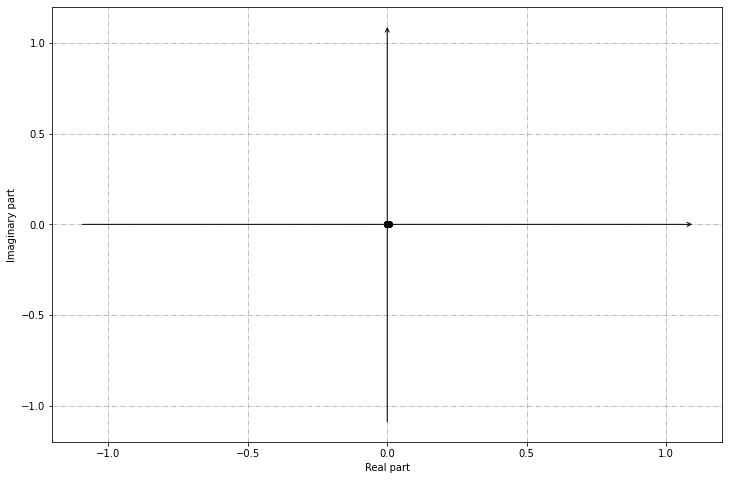

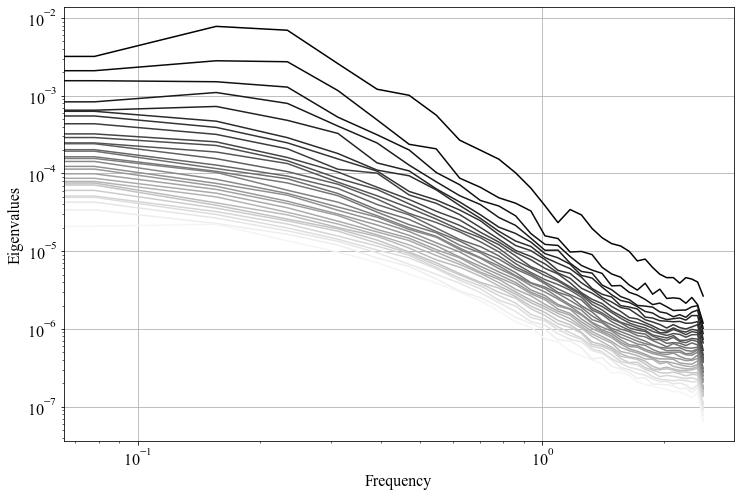

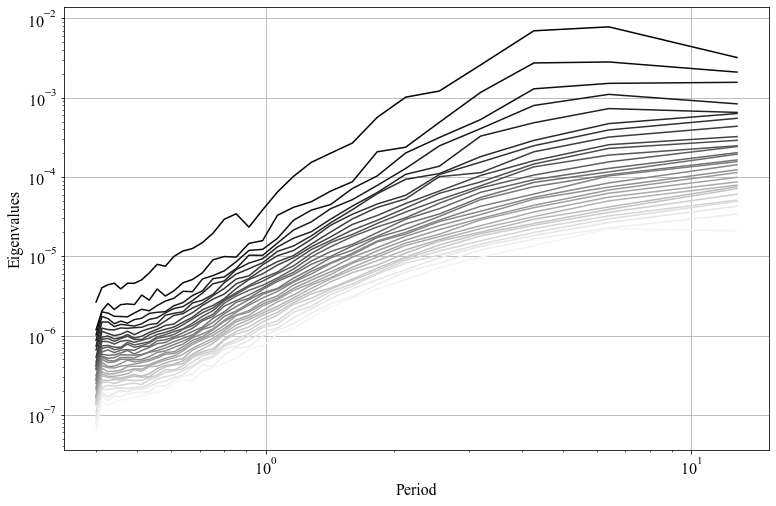

In [18]:
## only rank 0
if rank == 0:
    ## plot eigenvalues
    spod.plot_eigs()
    spod.plot_eigs_vs_frequency()
    spod.plot_eigs_vs_period()


### SPOD modes

We can then plot the SPOD modes at some prescribed frequencies (equivalently periods) of interest. 
In this case we chose 
- period 1, T1 = 0.9, and 
- period 2, T2 = 4.

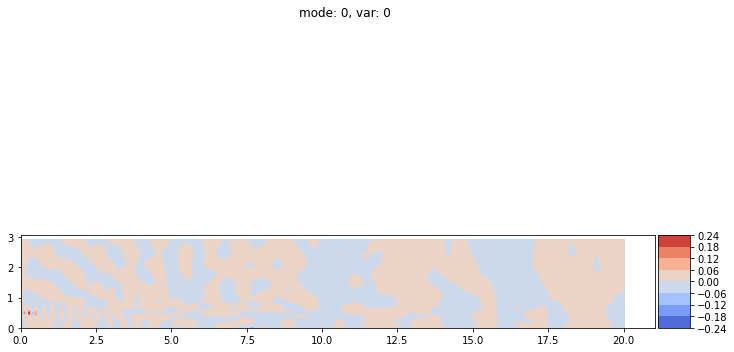

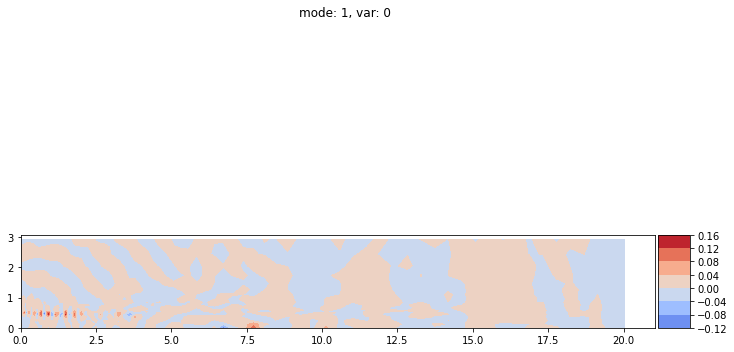

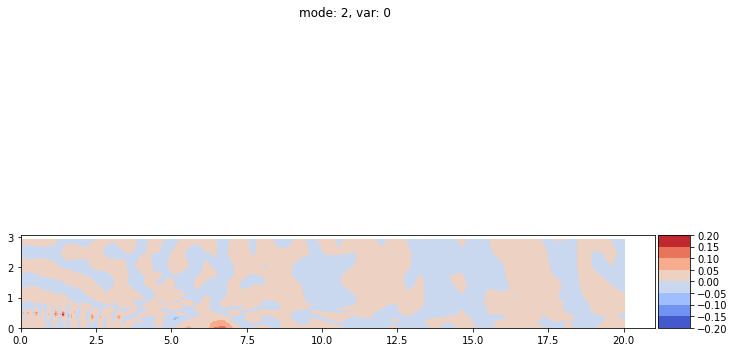

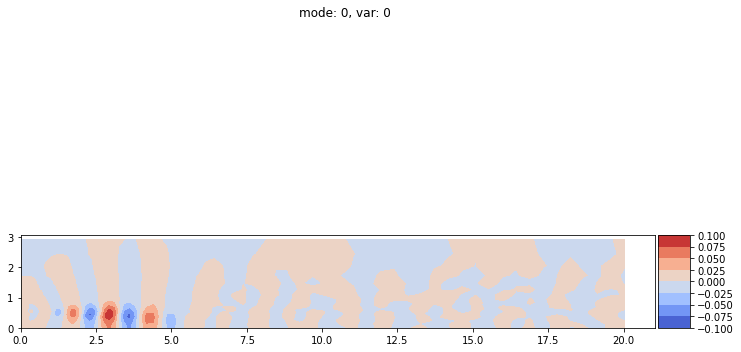

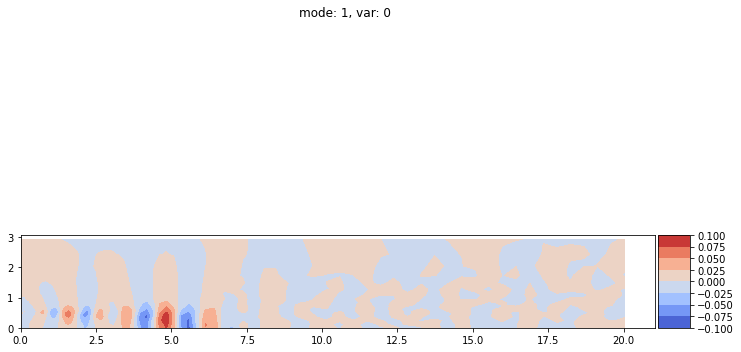

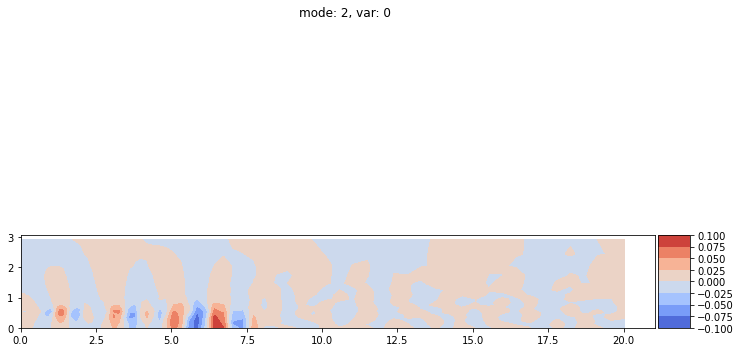

In [19]:
## only rank 0
if rank == 0:
    ## identify frequency of interest
    T1 = 0.9; T2 = 4
    f1, f1_idx = spod.find_nearest_freq(freq_req=1/T1, freq=spod.freq)
    f2, f2_idx = spod.find_nearest_freq(freq_req=1/T2, freq=spod.freq)

    ## plot 2d modes at frequency of interest
    spod.plot_2d_modes_at_frequency(freq_req=f1, freq=spod.freq,
        modes_idx=[0,1,2], x1=x2, x2=x1,
        equal_axes=True)

    ## plot 2d modes at frequency of interest
    spod.plot_2d_modes_at_frequency(freq_req=f2, freq=spod.freq,
        modes_idx=[0,1,2], x1=x2, x2=x1,
        equal_axes=True)



### Time coefficients

We can also visualize the time coefficients

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


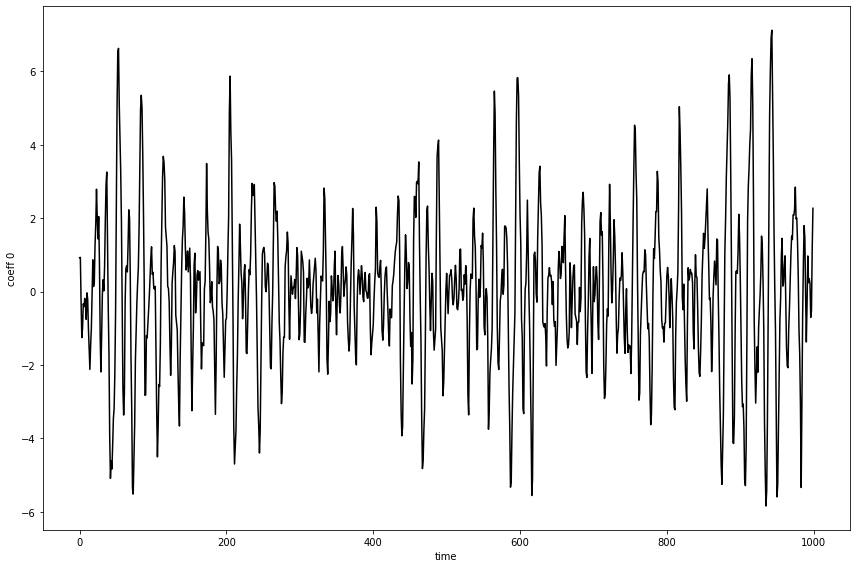

/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


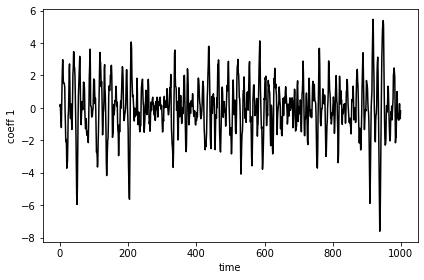

In [20]:
## only rank 0
if rank == 0:    
    ## plot coefficients
    coeffs = np.load(file_coeffs)
    post.plot_coeffs(coeffs, coeffs_idx=[0,1],
        path=results_dir)

  

### Reconstruction of the solution

We then visualize the reconstruction of the data based on the SPOD modes and time coefficients.

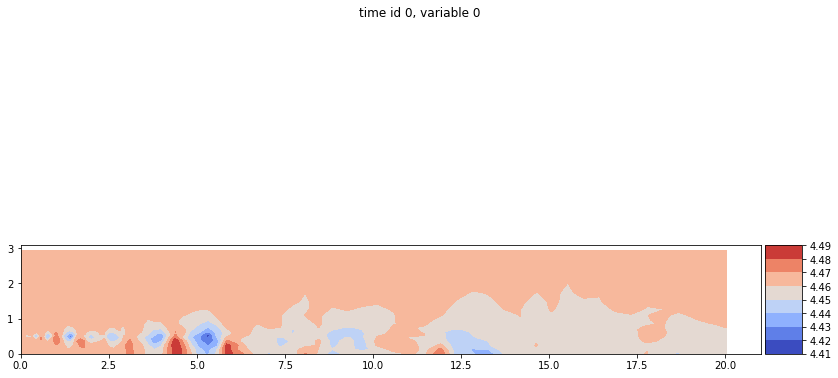

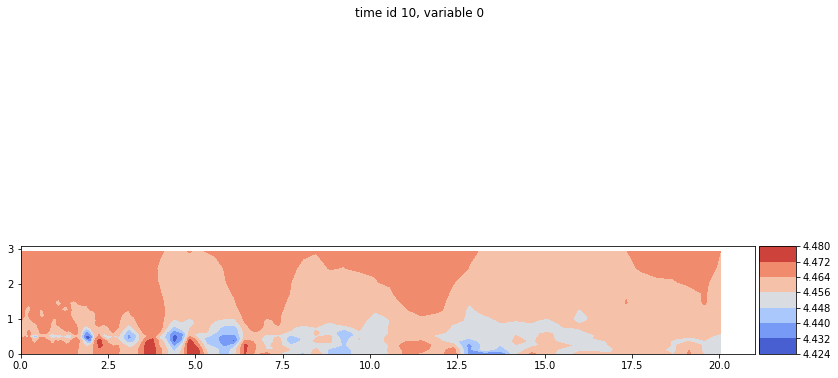

In [21]:
## only rank 0
if rank == 0:
    ## plot reconstruction
    recons = np.load(file_dynamics)
    post.plot_2d_data(recons, time_idx=[0,10],
        path=results_dir, x1=x2, x2=x1, equal_axes=True)



### The original data

We can also visualize the original data, both in terms of 2D contours or data tracers.

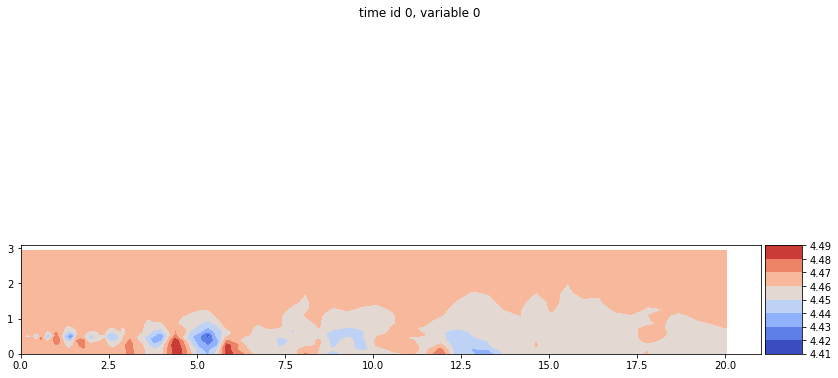

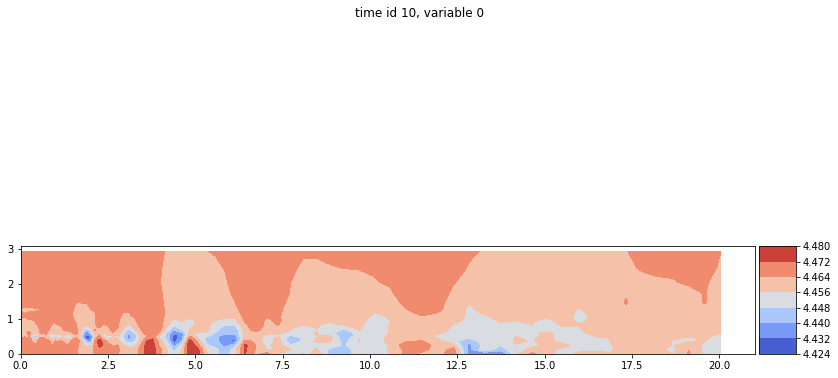

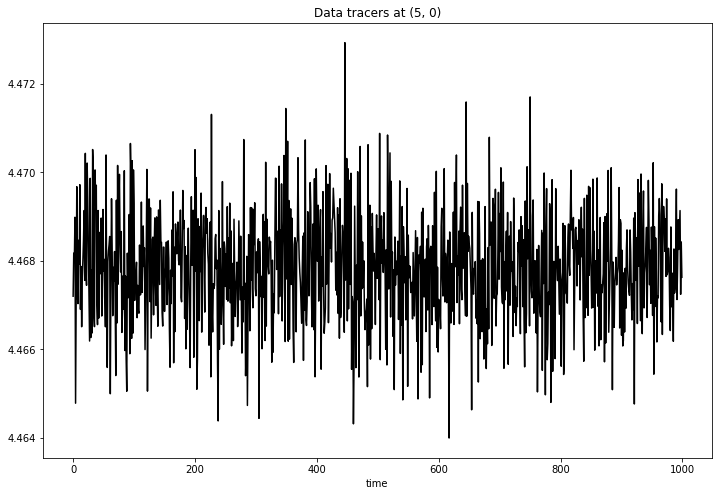

In [22]:
## only rank 0
if rank == 0:
    ## plot data
    data = spod.get_data(data)
    post.plot_2d_data(data, time_idx=[0,10],
        path=results_dir, x1=x2, x2=x1, equal_axes=True)
    post.plot_data_tracers(data, coords_list=[(5,0.5)],
        time_limits=[0,nt], path=results_dir)
    ## -------------------------------------------------------------